In [1]:
import tensorflow as tf
from datasets import load_dataset as ld
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import pandas as pd
import numpy as np

In [14]:
train_df, test_df = pd.read_csv('seed.csv'), pd.read_csv('test.csv')

In [15]:
total_df = pd.concat([train_df, test_df ],axis=0)

In [16]:
id_to_label = {id : label for id, label in enumerate(total_df.label.unique())}
label_to_id = {label : id  for id, label in enumerate(total_df.label.unique())}

In [17]:
train_df['label']= train_df['label'].map(label_to_id)
test_df['label'] = test_df['label'].map(label_to_id)

In [20]:
test_df['label'].skew()

-0.04906646633501807

In [19]:
train_df['label'].skew()

0.23817191405707058

- Processing Text Data

In [4]:
# Parameters 
vocab_size = 1000 
emebed_size = 20 
max_sequence_length = 14
epochs = 50
batch_size = 30 

In [6]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_test['example'])

## LSTM Text Classification Model


In [13]:
rnn_model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emebed_size,input_length = max_sequence_length), 
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(units=400,dropout=0.20),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(units=len(total_df.label.unique()), activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 20)            20000     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 14, 20)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 400)               673600    
                                                                 
 layer_normalization_2 (Laye  (None, 400)              800       
 rNormalization)                                                 
                                                                 
 dense (Dense)               (None, 77)                30877     
                                                                 
Total params: 725,277
Trainable params: 725,277
Non-trai

In [18]:
test_sequences = tokenizer.texts_to_sequences(test_df['example'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [19]:
from sklearn.metrics import precision_recall_fscore_support

In [20]:
label_count = 0 
accs = [] 
precisions = [] 
recalls = [] 
f1s = []
labels = []

for i in range(15):
    label_count += 10
    labels.append(label_count)
    
    sequences = tokenizer.texts_to_sequences(test_df['example'][:label_count])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    rnn_model.fit(padded_sequences, test_df['label'][:label_count], epochs=50,validation_data=(test_padded_sequences, test_df['label']))
    
    predictions = rnn_model.predict(test_padded_sequences)
    predicted_labels = np.argmax(predictions, axis=1)
    
    
    precision, recall, f1, _ = precision_recall_fscore_support(test_df['label'], predicted_labels, average='macro',zero_division=1)

    
    accs.append(accuracy_score(test_df['label'],predicted_labels))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    



Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 4.4499 - accuracy: 0.0000e+00 - val_loss: 4.3632 - val_accuracy: 0.0135
Epoch 2/50
1/1 [==============================] - 0s 290ms/step - loss: 3.9605 - accuracy: 0.1000 - val_loss: 4.4044 - val_accuracy: 0.0145
Epoch 3/50
1/1 [==============================] - 0s 276ms/step - loss: 3.5410 - accuracy: 0.1000 - val_loss: 4.5224 - val_accuracy: 0.0155
Epoch 4/50
1/1 [==============================] - 0s 285ms/step - loss: 3.1197 - accuracy: 0.3000 - val_loss: 4.8490 - val_accuracy: 0.0165
Epoch 5/50
1/1 [==============================] - 0s 276ms/step - loss: 2.5365 - accuracy: 0.3000 - val_loss: 5.6438 - val_accuracy: 0.0150
Epoch 6/50
1/1 [==============================] - 0s 288ms/step - loss: 2.0976 - accuracy: 0.5000 - val_loss: 6.9333 - val_accuracy: 0.0190
Epoch 7/50
1/1 [==============================] - 0s 296ms/step - loss: 1.8619 - accuracy: 0.4000 - val_loss: 8.3537 - val_accuracy: 0.0220
Epoch 8/50
1/1 [===

In [21]:
result_df = pd.DataFrame({'True_Label': test_df['label'], 'Predicted_Label': predicted_labels})

In [23]:
result_df.to_csv('evaluation/rnn_banking_label_predictions.csv', index=False)


In [24]:
metrics_df = pd.DataFrame({
    'Label': labels,
    'Accuracy': accs,
    'Precision': precisions,
    'Recall': recalls,
    'F1': f1s
})

In [25]:
metrics_df.to_csv('evaluation/RNN_banking_labels_metrics_result.csv', index=False)


In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

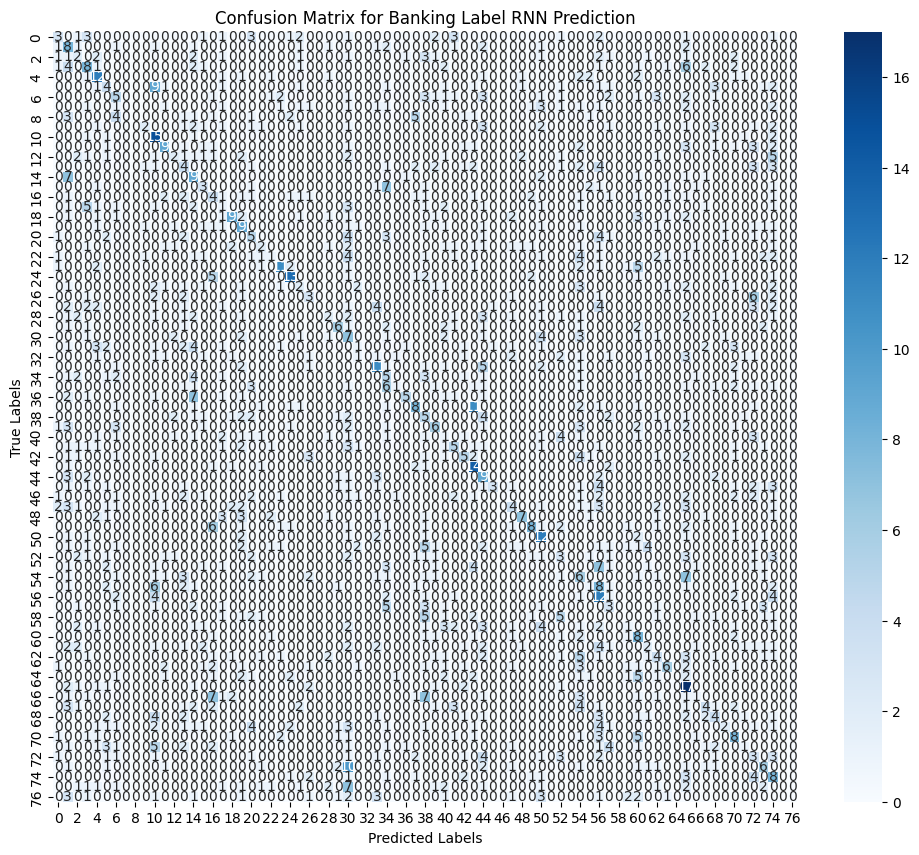

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Banking Label RNN Prediction')
plt.show()
# Save the heatmap as an image in the 'evaluation' folder
